In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a9408.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a1946.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a8141.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/h66.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a9001.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/h29.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a7351.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a7801.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a2852.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a8799.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a201.jpg
/kag

*Importing Necessary Libraries*

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.losses import CategoricalCrossentropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

*Loading Dataset*

In [7]:
train = r'/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset'

# Image data loading
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=24,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=True,
    crop_to_aspect_ratio=False,
)

Found 6323 files belonging to 5 classes.


*Data Augmentation*

In [8]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split 

# Define the paths to the data directories
data_dir = '/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset'
categories = ['F0', 'F1','F2','F3','F4'
        ]

In [9]:
img_size = 128  # Desired image size for resizing

def load_and_preprocess_images(data_dir, categories, img_size):
    data = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_label = categories.index(category)  # Assign class labels based on category index
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_array is not None:
                    resized_img = cv2.resize(img_array, (img_size, img_size))
                    data.append([resized_img, class_label])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue
    return data

In [10]:
# Load and preprocess images
data = load_and_preprocess_images(data_dir, categories, img_size)

# Shuffle the data to ensure random distribution
np.random.shuffle(data)

# Split data into features and labels
X, y = zip(*data)
X = np.array(X).reshape(-1, img_size, img_size, 1)  # Reshape for CNN input
y = np.array(y)

# Normalize pixel values to [0, 1]
X = X / 255.0

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (5058, 128, 128, 1)
Testing data shape: (1265, 128, 128, 1)


*Visualizing Images*

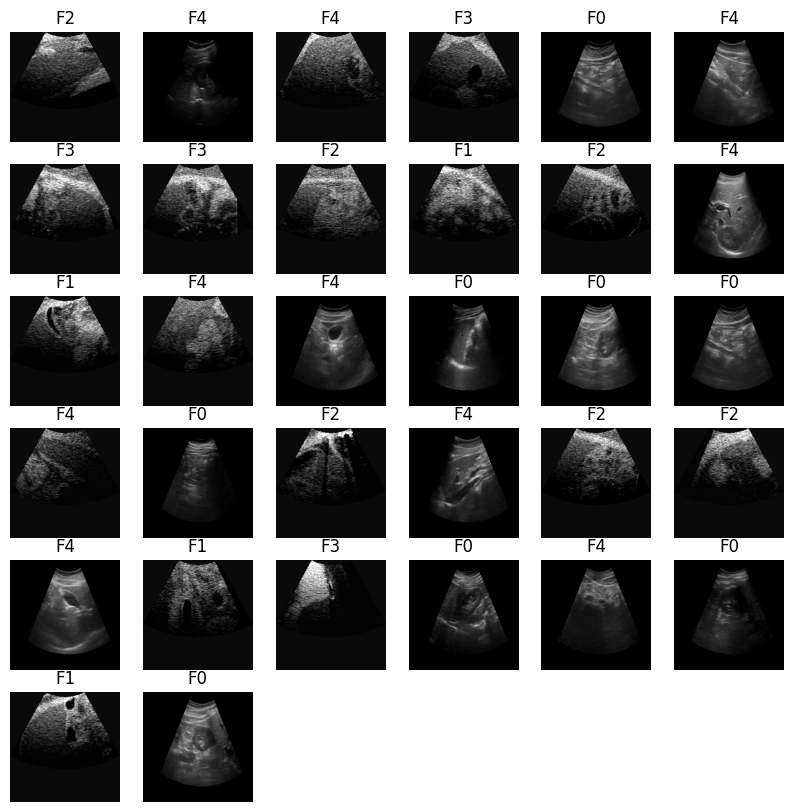

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
class_names = train_ds.class_names

for images, labels in train_ds.take(2):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Extract the class label from the one-hot encoded array
        class_label_index = int(np.argmax(labels[i]))
        plt.title(class_names[class_label_index])
        
        plt.axis("off")

plt.show()


*Grey Scale Image Classification*

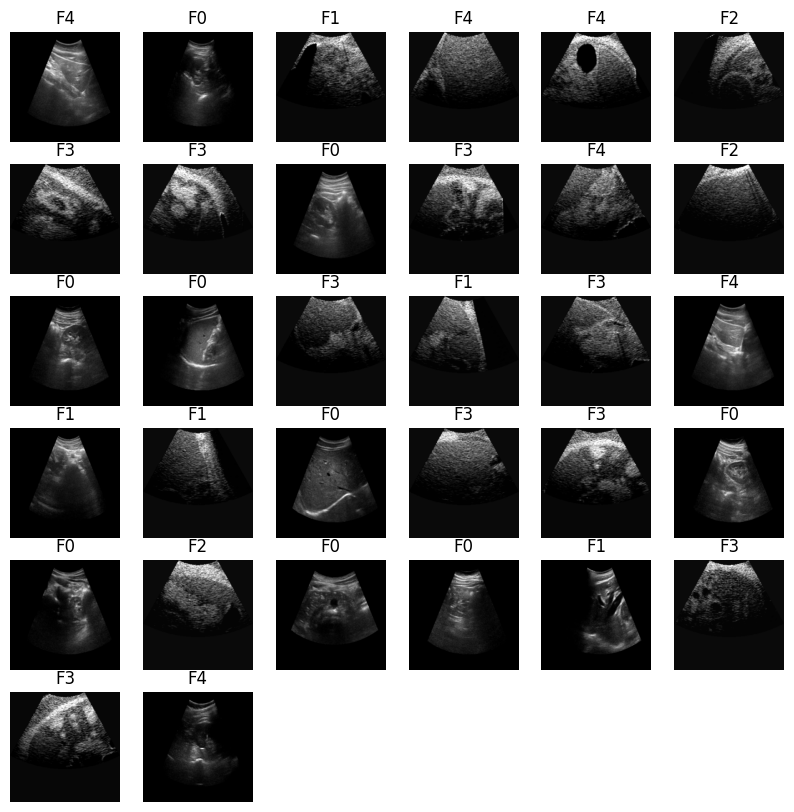

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
class_names = train_ds.class_names

for images, labels in train_ds.take(2):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        
        # Convert RGB image to grayscale
        grayscale_image = np.dot(images[i].numpy(), [0.2989, 0.5870, 0.1140])
        plt.imshow(grayscale_image, cmap='gray')
        
        # Extract the class label from the one-hot encoded array
        class_label_index = int(np.argmax(labels[i]))
        plt.title(class_names[class_label_index])
        
        plt.axis("off")

plt.show()

*Model Architecture*

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Output layer with units equal to number of categories
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


*Training The Model*

In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4891 - loss: 1.1303 - val_accuracy: 0.7708 - val_loss: 0.6023
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7562 - loss: 0.5930 - val_accuracy: 0.8743 - val_loss: 0.3834
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8592 - loss: 0.3540 - val_accuracy: 0.9154 - val_loss: 0.2615
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9034 - loss: 0.2496 - val_accuracy: 0.9542 - val_loss: 0.1853
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9326 - loss: 0.1864 - val_accuracy: 0.9628 - val_loss: 0.1579
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9526 - loss: 0.1304 - val_accuracy: 0.9739 - val_loss: 0.1161
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9584 - loss: 0.1148 - val_accuracy: 0.9692 - val_loss: 0.1128
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9676 - loss: 0.0878 - val_acc

*Visualizing Loss and Accuracy*

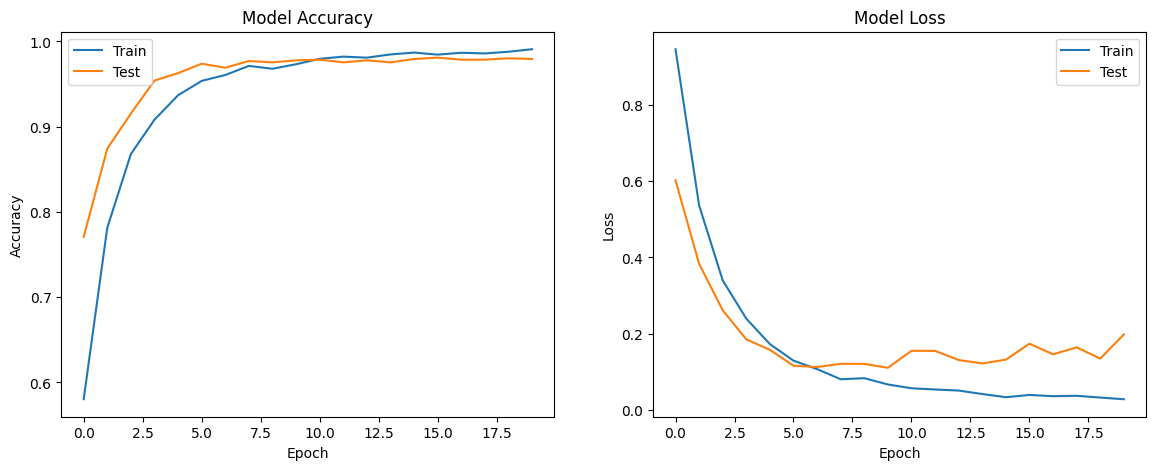

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()




*Final Accuracy*

In [17]:
# Evaluate the model on the training set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Final accuracy: {test_acc}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9857 - loss: 0.1483
Final accuracy: 0.9794466495513916


*Model Saving*

In [18]:
model.save('/kaggle/working/cnn_model.h5')

*User's Prediction*

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Define the CNN architecture
img_size = 224  # Updated to match the target size of the image

# Assuming 'model' is already defined
model = load_model('cnn_model.h5')
# Dictionary mapping class indices to class labels
class_dict = {
     0:'F0',
    1:'F1',
    2:'F2',
    3:'F3',
    4:'F4'
}


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Output layer with units equal to number of categories
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
# Assuming X_train, y_train, X_test, y_test are already prepared
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

# Load and preprocess the image
image_path = r'/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a1028.jpg'
from keras.utils import load_img, img_to_array

# Load and preprocess the image
image = load_img(image_path, target_size=(img_size, img_size), color_mode='grayscale')  # Use grayscale
img = img_to_array(image)  # Convert to array
img = img / 255.0  # Normalize pixel values to [0, 1]
img = img.reshape(1, img_size, img_size, 1)  # Reshape to match the input shape


# Make predictions
predictions = model.predict(img)
predicted_category = categories[np.argmax(predictions)]

print(f"Predicted category: {predicted_category}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted category: F0
